# Text-Based Ideal Points using Numpyro
### ___Szymon Sacher & Keyon Vafa___ This notebook replicates Text-Based Ideal Point model (Vafa, Naidu & Blei, 2020)

**IMPORTANT:** To save this code and your results, make sure you copy to your personal Google Drive. Under "File", select "Save a copy in Drive".

Use this Colab notebook to run a Numpyro implementation of the [text-based ideal point model (TBIP)](https://www.aclweb.org/anthology/2020.acl-main.475/) on a corpus of political text. The [Github repository is more complete](https://github.com/keyonvafa/tbip).

See also [Tensorflow implementation](https://colab.research.google.com/drive/1_KkVI2lGtPdgsHSKDIMhSLCKkHvBQ4LO#scrollTo=BLgkfNNZUZv5) on which this notebook is based.

The [TBIP](https://www.aclweb.org/anthology/2020.acl-main.475/) is an unsupervised probabilistic topic model that analyzes texts to quantify the political positions of its authors. The model does not use political parties or votes, nor does it require any text labelled by ideology. Given a corpus of political text and the authors of each document, the TBIP estimates the latent political positions of the authors of texts and how per-topic word choice changes as a function of the political position of the author ("ideological topics"). [Refer to the paper for more information](https://www.aclweb.org/anthology/2020.acl-main.475/).


## Getting started

First, **make sure you are running this Colab using a GPU**. Go to the "Runtime" menu, and click "Change runtime type". If the "Hardware accelerator" is listed as "None" or "TPU", change to "GPU". Click "Save" and you're ready to go. Also, as described in the first cell, make sure this code is copied to your personal Google Drive.

## Install Numpyro 

[Numpyro](https://github.com/pyro-ppl/numpyro) is a probabilistic programming with NumPy powered by JAX for autograd and JIT compilation to GPU/TPU/CPU.



In [ ]:
!pip install numpyro==0.10.1
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 5.1 MB/s 
     |████████████████████████████████| 85 kB 3.8 MB/s 


## Dependency imports


In [ ]:
import jax
from jax import jit
import jax.numpy as jnp
import pandas as pd
import numpy as np
from jax import random
import pandas as pd
import numpy as np
from scipy import sparse

*Below* we clone the [Github repo for the TBIP](https://github.com/keyonvafa/tbip). This is where the data resides.

In [ ]:
! git clone https://github.com/keyonvafa/tbip

Cloning into 'tbip'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 219 (delta 49), reused 72 (delta 38), pack-reused 131
Receiving objects: 100% (219/219), 61.77 MiB | 49.26 MiB/s, done.
Resolving deltas: 100% (100/100), done.


## Hyperparameters and Initialization

We start setting some hyperparameters. We fix the number of topics $K = 50$. We also set a random seed for reproducibility.

In [ ]:
num_topics = 50
rng_seed = random.PRNGKey(0)

The next cell provides the data directory. The directory in the cell below links to speeches from the 114th Senate session from the `tbip` repo.

To use your own corpus, upload the following four files to the Colab working directory:

* `counts.npz`: a `[num_documents, num_words]` [sparse CSR matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) containing the word counts for each document.
* `author_indices.npy`: a `[num_documents]` vector where each entry is an integer in the set `{0, 1, ..., num_authors - 1}`, indicating the author of the corresponding document in `counts.npz`.
* `vocabulary.txt`: a `[num_words]`-length file where each line denotes the corresponding word in the vocabulary.
* `author_map.txt`: a `[num_authors]`-length file where each line denotes the name of an author in the corpus.

See [Senate speech clean data](https://github.com/keyonvafa/tbip/tree/master/data/senate-speeches-114/clean) for an example of what the four files look like for Senate speeches. [Our setup script](https://github.com/keyonvafa/tbip/blob/master/setup/senate_speeches_to_bag_of_words.py) 
contains example code for creating the four files from unprocessed data for Senate speeches.

**IMPORTANT:** If you are using your own corpus, change the following line to `data_dir = '.'` after uploading the four files to the Colab working directory.


In [ ]:
dataPath = 'tbip/data/senate-speeches-114/clean/'

# Load data
author_indices = jax.device_put(jnp.load(dataPath + "author_indices.npy"), jax.devices("gpu")[0])

counts = sparse.load_npz(dataPath + "counts.npz")

with open(dataPath + "vocabulary.txt",'r') as f:
    vocabulary = f.readlines()

with open(dataPath + "author_map.txt",'r') as f:
    author_map = f.readlines()

author_map = np.array(author_map)

num_authors = int(author_indices.max() + 1)
num_documents, num_words = counts.shape

[In the paper](https://www.aclweb.org/anthology/2020.acl-main.475/), the parameters are pre-initialize with [Poisson factorization](https://arxiv.org/abs/1311.1704). Most of the time, we find this doesn't make a big difference for the learned ideal points, but it helps to interpret the ideological topics. 

Below, we initialize with Scikit-Learn's non-negative matrix factorization (NMF) implementation. Although we find that Poisson factorization learns more interpretable topics, we use Scikit-Learn's NMF implementation here because it is faster. To use Poisson factorization, see the [code in the Github repo](https://github.com/keyonvafa/tbip/blob/master/setup/poisson_factorization.py). 

If you would like to skip this pre-initialization step, set `pre_initialize_parameters = False` in the cell below. (Pre-initialization is recommended.)

In [ ]:
pre_initialize_parameters = True

If you are pre-initializing parameters, the following cell might take a minute or so.

In [ ]:
# Fit NMF to be used as initialization for TBIP
from sklearn.decomposition import NMF

if pre_initialize_parameters:
  nmf_model = NMF(n_components=num_topics, 
                  init='random', 
                  random_state=0, 
                  max_iter=500)
  # Define initialization arrays
  initial_document_loc = jnp.log(jnp.array(np.float32(nmf_model.fit_transform(counts) + 1e-2)))
  initial_objective_topic_loc = jnp.log(jnp.array(np.float32(nmf_model.components_ + 1e-2)))
else:
  rng1, rng2 = random.split(rng_seed, 2)
  initial_document_loc = random.normal(rng1,shape = (num_documents, num_topics))
  initial_objective_topic_loc = random.normal(rng2, shape =(num_topics, num_words))

## Perform Inference

We perform inference using [variational inference](https://arxiv.org/abs/1601.00670) with [reparameterization](https://arxiv.org/abs/1312.6114) [gradients](https://arxiv.org/abs/1401.4082). We provide a brief summary below, but encourage readers to [refer to the original paper](https://www.aclweb.org/anthology/2020.acl-main.475/) for a more complete overview.

It is intractable to evaluate the posterior distribution $p(\theta, \beta, \eta, x | y)$, so we approximate the posterior with a distribution $q_\phi(\theta, \beta,\eta,x)$, parameterized by $\phi$. How do we set the values $\phi$? We want to minimize the KL-Divergence between $q$ and the posterior, which is equivalent to maximizing the ELBO:
$$\mathbb{E}_{q_\phi}[\log p(y, \theta, \beta, \eta, x) - \log q_{\phi}(\theta, \beta, \eta, x)].$$
We set the variational family to be the mean-field family, meaning the latent variables factorize over documents $d$, topics $k$, and authors $s$:
$$q_\phi(\theta, \beta, \eta, x) = \prod_{d,k,s} q(\theta_d)q(\beta_k)q(\eta_k)q(x_s).$$
We use lognormal factors for the positive variables and Gaussian factors for the real variables:
$$q(\theta_d) = \text{LogNormal}_K(\mu_{\theta_d}\sigma^2_{\theta_d})$$
$$q(\theta_d) = \text{LogNormal}_V(\mu_{\beta_k}, \sigma^2_{\beta_k})$$
$$q(\eta_k) = \mathcal{N}_V(\mu_{\eta_k}, \sigma^2_{\eta_k})$$
$$q(x_s) = \mathcal{N}(\mu_{x_s}, \sigma^2_{x_s}).$$

Thus, our goal is to maximize the ELBO with respect to $\phi = \{\mu_\theta, \sigma_\theta, \mu_\beta, \sigma_\beta,\mu_\eta, \sigma_\eta, \mu_x, \sigma_x\}$. 

In the cell below, we define the model and the variational family (guide).

In [ ]:
from numpyro import plate, sample, param
import numpyro.distributions as dist
from numpyro.distributions import constraints

# Define the model and variational family

class TBIP:
    def __init__(self, N, D, K, V, batch_size, init_mu_theta = None, init_mu_beta = None):
        self.N = N # number of people 
        self.D = D # number of documents
        self.K = K # number of topics
        self.V = V # number of words in vocabulary
        self.batch_size = batch_size # number of documents in a batch

        if init_mu_theta is None:
            init_mu_theta = jnp.zeros([D, K])
        else:
            self.init_mu_theta = init_mu_theta
        
        if init_mu_beta is None:
            init_mu_beta = jnp.zeros([K, V])
        else:
            self.init_mu_beta = init_mu_beta
    
    def model(self, Y_batch, d_batch, i_batch):

        with plate("i", self.N):
            # Sample the per-unit latent variables (ideal points)
            x = sample("x", dist.Normal())
        
        with plate("k", size = self.K, dim = -2):
            with plate("k_v", size = self.V, dim = -1):
                beta = sample("beta", dist.Gamma(0.3, 0.3))
                eta = sample("eta", dist.Normal())

        with plate("d", size = self.D, subsample_size=self.batch_size, dim = -2):
            with plate("d_k", size = self.K, dim = -1):
                # Sample document-level latent variables (topic intensities)
                theta = sample("theta", dist.Gamma(0.3, 0.3))
            
            # Compute Poisson rates for each word
            P = jnp.sum(jnp.expand_dims(theta, 2) * jnp.expand_dims(beta, 0) *
                jnp.exp(jnp.expand_dims(x[i_batch], (1,2)) * jnp.expand_dims(eta, 0)), 1)

            with plate("v", size = self.V, dim = -1):
                # Sample observed words 
                sample("Y_batch", dist.Poisson(P), obs = Y_batch)

    def guide(self, Y_batch, d_batch, i_batch):
        # This defines variational family. Notice that each of the latent variables
        # defined in the sample statements in the model above has a corresponding
        # sample statement in the guide. The guide is responsible for providing
        # variational parameters for each of these latent variables.

        # Also notice it is required that model and the guide have the same call.

        mu_x = param("mu_x", init_value = -1  + 2 * random.uniform(random.PRNGKey(1), (self.N,)))
        sigma_x = param("sigma_y", init_value = jnp.ones([self.N]), constraint  = constraints.positive)
    
        mu_eta = param("mu_eta", init_value = random.normal(random.PRNGKey(2), (self.K,self.V)))
        sigma_eta = param("sigma_eta", init_value = jnp.ones([self.K,self.V]), constraint  = constraints.positive)

        mu_theta = param("mu_theta", init_value =  self.init_mu_theta)
        sigma_theta = param("sigma_theta", init_value =  jnp.ones([self.D, self.K]), constraint  = constraints.positive)
        
        mu_beta = param("mu_beta", init_value = self.init_mu_beta)
        sigma_beta = param("sigma_beta", init_value = jnp.ones([self.K, self.V]), constraint  = constraints.positive)

        with plate("i", self.N): 
            sample("x", dist.Normal(mu_x, sigma_x))
        
        with plate("k", size = self.K, dim = -2):
            with plate("k_v", size = self.V, dim = -1):
                sample("beta", dist.LogNormal(mu_beta, sigma_beta))
                sample("eta", dist.Normal(mu_eta, sigma_eta))

        with plate("d", size = self.D, subsample_size=self.batch_size, dim = -2):
            with plate("d_k", size = self.K, dim = -1):
                sample("theta", dist.LogNormal(mu_theta[d_batch], sigma_theta[d_batch]))
    
    def get_batch(self, rng, Y, author_indices):
        # Helper functions to obtain a batch of data, convert from scipy.sparse to jax.numpy.array and move to gpu
        D_batch = jax.random.choice(rng, jnp.arange(self.D), shape = (self.batch_size,))
        Y_batch = jax.device_put(jnp.array(Y[D_batch].toarray()), jax.devices("gpu")[0])
        D_batch = jax.device_put(D_batch, jax.devices("gpu")[0])
        I_batch = author_indices[D_batch]
        return Y_batch, I_batch, D_batch

## Initialization

Below we initialize an instance of the TBIP model, and associated SVI object. The latter is used to compute the Evidence Lower Bound (ELBO) given current value of guide's parameters and current batch of data.

We optimize the model using Adam with exponential decay of learning rate.  

In [ ]:
# Initialize the model
from optax import adam, exponential_decay
from numpyro.infer import SVI, TraceMeanField_ELBO

num_steps = 50000
batch_size = 512

tbip = TBIP(
    N = num_authors,
    D = num_documents,
    K = num_topics,
    V = num_words,
    batch_size = batch_size,
    init_mu_theta = initial_document_loc,
    init_mu_beta = initial_objective_topic_loc)

svi_batch = SVI(
    model=tbip.model,
    guide=tbip.guide, 
    optim = adam(exponential_decay(0.01, num_steps, 0.01)),
    loss = TraceMeanField_ELBO())

# Compile update function for faster training
svi_batch_update = jit(svi_batch.update)

# Get initial batch. This informs the dimension of arrays and ensures they are
# consistent with dimensions (N, D, K, V) defined above. 
Y_batch, I_batch, D_batch = tbip.get_batch(random.PRNGKey(1), counts, author_indices)

# Initialize the parameters using initial batch
svi_state = svi_batch.init(
    random.PRNGKey(0),
    Y_batch = Y_batch,
    d_batch = D_batch,
    i_batch = I_batch)


In [ ]:
#@title Run this cell to create helper functions for printing topics and ordered ideal points

def get_topics(neutral_mean, 
               negative_mean, 
               positive_mean, 
               vocabulary, 
               print_to_terminal=True):
  num_topics, num_words = neutral_mean.shape
  words_per_topic = 10
  top_neutral_words = np.argsort(-neutral_mean, axis=1)
  top_negative_words = np.argsort(-negative_mean, axis=1)
  top_positive_words = np.argsort(-positive_mean, axis=1)
  topic_strings = []
  for topic_idx in range(num_topics):
    neutral_start_string = "Neutral  {}:".format(topic_idx)
    neutral_row = [vocabulary[word] for word in 
                    top_neutral_words[topic_idx, :words_per_topic]]
    neutral_row_string = ", ".join(neutral_row)
    neutral_string = " ".join([neutral_start_string, neutral_row_string])
    
    positive_start_string = "Positive {}:".format(topic_idx)
    positive_row = [vocabulary[word] for word in 
                    top_positive_words[topic_idx, :words_per_topic]]
    positive_row_string = ", ".join(positive_row)
    positive_string = " ".join([positive_start_string, positive_row_string])
    
    negative_start_string = "Negative {}:".format(topic_idx)
    negative_row = [vocabulary[word] for word in 
                    top_negative_words[topic_idx, :words_per_topic]]
    negative_row_string = ", ".join(negative_row)
    negative_string = " ".join([negative_start_string, negative_row_string])
    
    if print_to_terminal:
      topic_strings.append(negative_string)
      topic_strings.append(neutral_string)
      topic_strings.append(positive_string)
      topic_strings.append("==========")
    else:
      topic_strings.append("  \n".join(
        [negative_string, neutral_string, positive_string]))
  
  if print_to_terminal:
    all_topics = "{}\n".format(np.array(topic_strings))
  else:
    all_topics = np.array(topic_strings)
  return all_topics

## Execute Training
The code above was creating the model; below we actually run training. You can adjust the number of steps to train (num_steps, defined above) and the frequency at which to print the ELBO (print_steps, defined below).

In [ ]:
print_steps = 100

Here, we run our training loop. Topic summaries and ordered ideal points will print every 2500 steps. Typically in our experiments it takes 15,000 steps or so to begin seeing sensible results, but of course this depends on the corpus. These sensible results should be reached within a half hour. For the default corpus of Senate speeches, it should take less than 2 hours to complete the full 50,000 training steps. 


In [ ]:
# Run SVI
from tqdm import tqdm

rngs = random.split(random.PRNGKey(2), num_steps)
losses = []
pbar = tqdm(range(num_steps))

for step in pbar:
    Y_batch, I_batch, D_batch = tbip.get_batch(rngs[step], counts, author_indices)
    svi_state, loss = svi_batch_update(svi_state, 
        Y_batch = Y_batch,
        d_batch = D_batch,
        i_batch = I_batch)

    loss = loss/counts.shape[0]
    losses.append(loss)
    if step%print_steps == 0 or step == num_steps - 1:
        pbar.set_description("Init loss: " + "{:10.4f}".format(jnp.array(losses[0])) +
         "; Avg loss (last 100 iter): " + "{:10.4f}".format(jnp.array(losses[-100:]).mean()))
    
    if (step + 1) % 2500 == 0 or step == num_steps - 1:

        print(f"Results after {step} steps.")
        estimated_params = svi_batch.get_params(svi_state)

        neutral_mean = estimated_params["mu_beta"] + estimated_params["sigma_beta"]**2/2

        positive_mean = (estimated_params["mu_beta"] + estimated_params["mu_eta"] +
            (estimated_params["sigma_beta"]**2 + estimated_params["sigma_eta"]**2 )/2)

        negative_mean = (estimated_params["mu_beta"] - estimated_params["mu_eta"] +
            (estimated_params["sigma_beta"]**2 + estimated_params["sigma_eta"]**2 )/2)

        np.save("neutral_topic_mean.npy", neutral_mean)
        np.save("negative_topic_mean.npy", positive_mean)
        np.save("positive_topic_mean.npy", negative_mean)

        topics = get_topics(neutral_mean, 
                            positive_mean, 
                            negative_mean, 
                            vocabulary)
        
        with open('topics.txt', 'w') as f:
            print(topics, file=f)
        print(topics)

        authors = pd.DataFrame({"name": author_map, "ideal_point" :  estimated_params["mu_x"]})
        authors.to_csv("authors.csv")
        
        sorted_authors = "Authors sorted by their ideal points: " + \
          ",".join(list(authors.sort_values("ideal_point")["name"]))
        
        print(sorted_authors.replace("\n", " "))


Init loss: 14323.9385; Avg loss (last 100 iter):   683.3360:  20%|█▉        | 9999/50000 [15:24<1:02:16, 10.70it/s]

Results after 9999 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   703.2635:  20%|██        | 10001/50000 [15:25<1:40:01,  6.66it/s]

['Negative 0: way\n, things\n, something\n, actually\n, lot\n, pilot\n, really\n, america\n, cant\n, good\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, really\n, actually\n, cant\n, good\n, america\n, talking\n'
 'Positive 0: way\n, something\n, things\n, lot\n, really\n, put\n, talking\n, cant\n, actually\n, lets\n'
 '=========='
 'Negative 1: military\n, defense\n, keep\n, costs\n, nation\n, army\n, answer\n, kissinger\n, air force\n, troops\n'
 'Neutral  1: military\n, defense\n, department\n, troops\n, army\n, national security\n, men\n, armed services\n, training\n, air force\n'
 'Positive 1: military\n, defense\n, department\n, general\n, troops\n, ever\n, national security\n, army\n, men\n, run\n'
 '=========='
 'Negative 2: trade\n, china\n, countries\n, exports\n, tpp\n, manufacturers\n, trade agreements\n, jobs\n, africa\n, united states\n'
 'Neutral  2: trade\n, countries\n, trade agreements\n, tpa\n, united states\n, tpp\n, trade promotion authority\n, jobs\n, curre

Init loss: 14323.9385; Avg loss (last 100 iter):   657.9286:  25%|██▍       | 12499/50000 [19:18<58:30, 10.68it/s]

Results after 12499 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   654.8365:  25%|██▌       | 12501/50000 [19:19<1:31:13,  6.85it/s]

['Negative 0: way\n, things\n, something\n, lot\n, actually\n, really\n, america\n, cant\n, put\n, good\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, really\n, actually\n, put\n, cant\n, good\n, america\n'
 'Positive 0: way\n, something\n, things\n, lot\n, really\n, put\n, talking\n, actually\n, cant\n, didnt\n'
 '=========='
 'Negative 1: military\n, defense\n, nation\n, keep\n, army\n, costs\n, department\n, answer\n, troops\n, men\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, troops\n, men\n, national security\n, armed services\n, training\n, general\n'
 'Positive 1: military\n, defense\n, department\n, national security\n, troops\n, army\n, men\n, ever\n, general\n, armed services\n'
 '=========='
 'Negative 2: trade\n, china\n, countries\n, exports\n, tpp\n, united states\n, manufacturers\n, trade agreements\n, jobs\n, africa\n'
 'Neutral  2: trade\n, countries\n, tpa\n, trade agreements\n, united states\n, jobs\n, tpp\n, trade promotion authority\n, curren

Init loss: 14323.9385; Avg loss (last 100 iter):   651.9978:  30%|██▉       | 14999/50000 [23:13<53:56, 10.81it/s]

Results after 14999 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   646.1109:  30%|███       | 15001/50000 [23:13<1:25:26,  6.83it/s]

['Negative 0: way\n, things\n, something\n, lot\n, america\n, actually\n, really\n, put\n, good\n, cant\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, really\n, actually\n, put\n, cant\n, america\n, good\n'
 'Positive 0: way\n, something\n, things\n, lot\n, really\n, talking\n, put\n, cant\n, actually\n, didnt\n'
 '=========='
 'Negative 1: military\n, defense\n, nation\n, keep\n, army\n, answer\n, department\n, troops\n, men\n, armed services\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, troops\n, men\n, national security\n, armed services\n, nation\n, women\n'
 'Positive 1: military\n, defense\n, department\n, troops\n, men\n, army\n, national security\n, women\n, armed services\n, general\n'
 '=========='
 'Negative 2: trade\n, china\n, countries\n, tpp\n, exports\n, united states\n, jobs\n, trade agreements\n, manufacturers\n, world\n'
 'Neutral  2: trade\n, countries\n, tpa\n, trade agreements\n, united states\n, jobs\n, tpp\n, trade promotion authority\n, c

Init loss: 14323.9385; Avg loss (last 100 iter):   643.5588:  35%|███▍      | 17498/50000 [27:07<50:09, 10.80it/s]

Results after 17499 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   646.0843:  35%|███▌      | 17501/50000 [27:07<1:15:47,  7.15it/s]

['Negative 0: way\n, things\n, something\n, lot\n, america\n, good\n, actually\n, really\n, put\n, cant\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, really\n, actually\n, put\n, cant\n, america\n, good\n'
 'Positive 0: way\n, something\n, things\n, lot\n, really\n, talking\n, put\n, actually\n, cant\n, country\n'
 '=========='
 'Negative 1: military\n, defense\n, department\n, answer\n, army\n, nation\n, keep\n, men\n, air force\n, national security\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, troops\n, women\n, national security\n, nation\n, armed services\n'
 'Positive 1: military\n, defense\n, troops\n, men\n, department\n, army\n, women\n, national security\n, armed services\n, general\n'
 '=========='
 'Negative 2: trade\n, china\n, countries\n, tpp\n, united states\n, exports\n, trade agreements\n, jobs\n, world\n, currency\n'
 'Neutral  2: trade\n, countries\n, tpa\n, united states\n, trade agreements\n, jobs\n, tpp\n, trade promotion authority\n

Init loss: 14323.9385; Avg loss (last 100 iter):   643.8200:  40%|███▉      | 19999/50000 [31:01<46:25, 10.77it/s]

Results after 19999 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   635.4754:  40%|████      | 20001/50000 [31:02<1:16:56,  6.50it/s]

['Negative 0: way\n, things\n, america\n, lot\n, something\n, good\n, really\n, cant\n, put\n, actually\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, really\n, actually\n, america\n, country\n, put\n, cant\n'
 'Positive 0: way\n, something\n, things\n, lot\n, talking\n, really\n, actually\n, country\n, put\n, cant\n'
 '=========='
 'Negative 1: defense\n, military\n, department\n, army\n, answer\n, national security\n, keep\n, air force\n, men\n, secretary\n'
 'Neutral  1: military\n, defense\n, department\n, men\n, army\n, troops\n, women\n, national security\n, nation\n, armed services\n'
 'Positive 1: military\n, defense\n, troops\n, women\n, men\n, nation\n, armed services\n, training\n, general\n, army\n'
 '=========='
 'Negative 2: trade\n, china\n, tpp\n, countries\n, united states\n, trade agreements\n, jobs\n, exports\n, world\n, fasttrack\n'
 'Neutral  2: trade\n, countries\n, tpa\n, united states\n, trade agreements\n, jobs\n, tpp\n, trade promotion authority\n, expo

Init loss: 14323.9385; Avg loss (last 100 iter):   639.5500:  45%|████▍     | 22499/50000 [34:56<42:39, 10.74it/s]

Results after 22499 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   639.2501:  45%|████▌     | 22501/50000 [34:56<1:07:02,  6.84it/s]

['Negative 0: way\n, things\n, america\n, good\n, lot\n, something\n, really\n, cant\n, country\n, give\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, really\n, actually\n, country\n, put\n, america\n, cant\n'
 'Positive 0: something\n, way\n, talking\n, lot\n, things\n, actually\n, really\n, country\n, put\n, talked\n'
 '=========='
 'Negative 1: defense\n, department\n, military\n, national security\n, answer\n, army\n, oco\n, medical research\n, secretary\n, keep\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, troops\n, women\n, national security\n, nation\n, armed services\n'
 'Positive 1: military\n, troops\n, women\n, nation\n, men\n, training\n, defense\n, armed services\n, general\n, army\n'
 '=========='
 'Negative 2: trade\n, tpp\n, countries\n, china\n, trade agreements\n, united states\n, jobs\n, fasttrack\n, exports\n, currency\n'
 'Neutral  2: trade\n, countries\n, tpa\n, united states\n, trade agreements\n, jobs\n, tpp\n, exports\n, trade prom

Init loss: 14323.9385; Avg loss (last 100 iter):   638.3436:  50%|████▉     | 24999/50000 [38:50<38:45, 10.75it/s]

Results after 24999 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   628.2518:  50%|█████     | 25001/50000 [38:51<1:01:19,  6.79it/s]

['Negative 0: america\n, way\n, things\n, good\n, lot\n, cant\n, really\n, give\n, something\n, maybe\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, really\n, country\n, actually\n, put\n, cant\n, america\n'
 'Positive 0: way\n, something\n, talking\n, lot\n, actually\n, things\n, country\n, really\n, talked\n, issue\n'
 '=========='
 'Negative 1: defense\n, department\n, military\n, medical research\n, national security\n, oco\n, army\n, answer\n, secretary\n, sequestration\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: military\n, troops\n, nation\n, women\n, training\n, men\n, armed services\n, missions\n, general\n, commander\n'
 '=========='
 'Negative 2: trade\n, tpp\n, china\n, countries\n, trade agreements\n, fasttrack\n, jobs\n, united states\n, wages\n, japan\n'
 'Neutral  2: trade\n, countries\n, united states\n, tpa\n, jobs\n, trade agreements\n, tpp\n, exports\n, 

Init loss: 14323.9385; Avg loss (last 100 iter):   633.5350:  55%|█████▍    | 27499/50000 [42:45<34:38, 10.83it/s]

Results after 27499 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   638.0599:  55%|█████▌    | 27501/50000 [42:46<54:28,  6.88it/s]

['Negative 0: america\n, way\n, things\n, good\n, give\n, cant\n, really\n, maybe\n, never\n, went\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, really\n, country\n, actually\n, put\n, cant\n, america\n'
 'Positive 0: way\n, something\n, talking\n, actually\n, lot\n, country\n, things\n, talked\n, really\n, issue\n'
 '=========='
 'Negative 1: defense\n, department\n, military\n, medical research\n, oco\n, sequestration\n, national security\n, secretary\n, answer\n, army\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: military\n, troops\n, nation\n, women\n, training\n, men\n, armed services\n, missions\n, united states\n, threats\n'
 '=========='
 'Negative 2: trade\n, tpp\n, china\n, countries\n, fasttrack\n, trade agreements\n, united states\n, jobs\n, wages\n, japan\n'
 'Neutral  2: trade\n, countries\n, united states\n, tpa\n, trade agreements\n, jobs\n, tpp\n, exports\n,

Init loss: 14323.9385; Avg loss (last 100 iter):   633.3600:  60%|█████▉    | 29999/50000 [46:40<31:00, 10.75it/s]

Results after 29999 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   634.8521:  60%|██████    | 30001/50000 [46:40<49:35,  6.72it/s]

['Negative 0: america\n, things\n, way\n, good\n, cant\n, maybe\n, give\n, never\n, tell\n, went\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, country\n, really\n, actually\n, put\n, cant\n, america\n'
 'Positive 0: way\n, talking\n, actually\n, something\n, lot\n, country\n, talked\n, things\n, issue\n, really\n'
 '=========='
 'Negative 1: defense\n, department\n, military\n, medical research\n, oco\n, sequestration\n, national security\n, agencies\n, nondefense\n, secretary\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: troops\n, military\n, nation\n, women\n, training\n, men\n, armed services\n, missions\n, united states\n, threats\n'
 '=========='
 'Negative 2: trade\n, tpp\n, china\n, countries\n, fasttrack\n, trade agreements\n, united states\n, jobs\n, wages\n, korea\n'
 'Neutral  2: trade\n, countries\n, united states\n, tpa\n, jobs\n, trade agreements\n, tpp\n, expo

Init loss: 14323.9385; Avg loss (last 100 iter):   627.3117:  65%|██████▍   | 32499/50000 [50:35<27:29, 10.61it/s]

Results after 32499 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   636.2830:  65%|██████▌   | 32501/50000 [50:35<43:18,  6.73it/s]

['Negative 0: america\n, things\n, way\n, give\n, never\n, maybe\n, cant\n, good\n, went\n, put\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, country\n, really\n, actually\n, put\n, cant\n, america\n'
 'Positive 0: way\n, actually\n, talking\n, something\n, lot\n, country\n, talked\n, things\n, issue\n, body\n'
 '=========='
 'Negative 1: defense\n, department\n, military\n, medical research\n, oco\n, sequestration\n, agencies\n, national security\n, secretary\n, dod\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: troops\n, military\n, nation\n, women\n, training\n, men\n, armed services\n, united states\n, missions\n, air force\n'
 '=========='
 'Negative 2: trade\n, tpp\n, china\n, fasttrack\n, countries\n, jobs\n, united states\n, trade agreements\n, wages\n, korea\n'
 'Neutral  2: trade\n, countries\n, united states\n, jobs\n, tpa\n, trade agreements\n, tpp\n, exports\n, c

Init loss: 14323.9385; Avg loss (last 100 iter):   633.7026:  70%|██████▉   | 34999/50000 [54:29<23:15, 10.75it/s]

Results after 34999 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   634.7299:  70%|███████   | 35001/50000 [54:30<37:03,  6.74it/s]

['Negative 0: america\n, way\n, things\n, never\n, give\n, maybe\n, cant\n, went\n, good\n, tell\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, country\n, really\n, actually\n, put\n, cant\n, america\n'
 'Positive 0: actually\n, way\n, talking\n, something\n, lot\n, country\n, talked\n, things\n, issue\n, body\n'
 '=========='
 'Negative 1: defense\n, department\n, medical research\n, military\n, oco\n, sequestration\n, agencies\n, national security\n, secretary\n, dod\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: troops\n, military\n, nation\n, women\n, training\n, men\n, armed services\n, united states\n, missions\n, air force\n'
 '=========='
 'Negative 2: trade\n, fasttrack\n, tpp\n, china\n, countries\n, united states\n, jobs\n, trade agreements\n, wages\n, korea\n'
 'Neutral  2: trade\n, countries\n, united states\n, jobs\n, tpa\n, trade agreements\n, tpp\n, exports\n, 

Init loss: 14323.9385; Avg loss (last 100 iter):   636.6650:  75%|███████▍  | 37499/50000 [58:25<19:31, 10.67it/s]

Results after 37499 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   632.1863:  75%|███████▌  | 37501/50000 [58:25<31:13,  6.67it/s]

['Negative 0: america\n, things\n, way\n, never\n, give\n, maybe\n, went\n, cant\n, good\n, tell\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, country\n, really\n, actually\n, put\n, cant\n, talking\n'
 'Positive 0: actually\n, way\n, talking\n, something\n, lot\n, country\n, talked\n, things\n, issue\n, body\n'
 '=========='
 'Negative 1: department\n, defense\n, medical research\n, military\n, oco\n, agencies\n, sequestration\n, national security\n, secretary\n, approach\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: troops\n, military\n, nation\n, women\n, training\n, men\n, united states\n, armed services\n, missions\n, air force\n'
 '=========='
 'Negative 2: trade\n, fasttrack\n, tpp\n, china\n, countries\n, united states\n, jobs\n, wages\n, korea\n, trade agreements\n'
 'Neutral  2: trade\n, countries\n, united states\n, jobs\n, tpa\n, trade agreements\n, tpp\n, export

Init loss: 14323.9385; Avg loss (last 100 iter):   634.0175:  80%|███████▉  | 39999/50000 [1:02:20<15:34, 10.70it/s]

Results after 39999 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   630.1188:  80%|████████  | 40001/50000 [1:02:20<24:34,  6.78it/s]

['Negative 0: america\n, things\n, way\n, never\n, give\n, maybe\n, cant\n, went\n, good\n, tell\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, country\n, really\n, actually\n, put\n, cant\n, talking\n'
 'Positive 0: actually\n, way\n, talking\n, something\n, lot\n, country\n, talked\n, things\n, issue\n, body\n'
 '=========='
 'Negative 1: department\n, defense\n, medical research\n, military\n, oco\n, agencies\n, sequestration\n, national security\n, approach\n, secretary\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: troops\n, military\n, women\n, nation\n, training\n, men\n, united states\n, armed services\n, missions\n, air force\n'
 '=========='
 'Negative 2: trade\n, fasttrack\n, china\n, tpp\n, countries\n, united states\n, wages\n, korea\n, jobs\n, billion\n'
 'Neutral  2: trade\n, countries\n, united states\n, trade agreements\n, tpa\n, jobs\n, tpp\n, exports\n, chin

Init loss: 14323.9385; Avg loss (last 100 iter):   629.1962:  85%|████████▍ | 42499/50000 [1:06:14<11:40, 10.71it/s]

Results after 42499 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   635.4376:  85%|████████▌ | 42501/50000 [1:06:15<18:13,  6.86it/s]

['Negative 0: america\n, things\n, way\n, never\n, maybe\n, give\n, went\n, tell\n, cant\n, good\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, country\n, really\n, actually\n, put\n, cant\n, talking\n'
 'Positive 0: actually\n, way\n, talking\n, something\n, lot\n, country\n, talked\n, things\n, issue\n, body\n'
 '=========='
 'Negative 1: department\n, defense\n, medical research\n, military\n, oco\n, agencies\n, sequestration\n, national security\n, approach\n, dod\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: troops\n, military\n, nation\n, women\n, training\n, men\n, united states\n, armed services\n, missions\n, air force\n'
 '=========='
 'Negative 2: trade\n, fasttrack\n, china\n, tpp\n, countries\n, wages\n, korea\n, united states\n, jobs\n, billion\n'
 'Neutral  2: trade\n, countries\n, united states\n, jobs\n, trade agreements\n, tpa\n, tpp\n, exports\n, china\n, t

Init loss: 14323.9385; Avg loss (last 100 iter):   631.6860:  90%|████████▉ | 44999/50000 [1:10:09<07:50, 10.64it/s]

Results after 44999 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   634.4606:  90%|█████████ | 45001/50000 [1:10:10<12:25,  6.71it/s]

['Negative 0: america\n, things\n, way\n, never\n, maybe\n, give\n, went\n, tell\n, cant\n, good\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, country\n, really\n, actually\n, put\n, cant\n, talking\n'
 'Positive 0: actually\n, way\n, talking\n, something\n, lot\n, country\n, talked\n, things\n, issue\n, state\n'
 '=========='
 'Negative 1: department\n, defense\n, medical research\n, military\n, oco\n, agencies\n, sequestration\n, national security\n, approach\n, dod\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: troops\n, nation\n, military\n, women\n, training\n, men\n, united states\n, armed services\n, missions\n, air force\n'
 '=========='
 'Negative 2: trade\n, fasttrack\n, china\n, tpp\n, wages\n, countries\n, korea\n, united states\n, jobs\n, billion\n'
 'Neutral  2: trade\n, countries\n, united states\n, jobs\n, trade agreements\n, tpa\n, tpp\n, exports\n, china\n, 

Init loss: 14323.9385; Avg loss (last 100 iter):   631.2081:  95%|█████████▍| 47499/50000 [1:14:04<03:56, 10.60it/s]

Results after 47499 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   629.1519:  95%|█████████▌| 47501/50000 [1:14:05<06:06,  6.82it/s]

['Negative 0: america\n, things\n, way\n, never\n, maybe\n, give\n, went\n, tell\n, cant\n, good\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, country\n, really\n, actually\n, put\n, cant\n, talking\n'
 'Positive 0: actually\n, way\n, talking\n, something\n, lot\n, country\n, talked\n, issue\n, things\n, body\n'
 '=========='
 'Negative 1: department\n, defense\n, medical research\n, military\n, oco\n, agencies\n, sequestration\n, national security\n, approach\n, dod\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: troops\n, women\n, nation\n, military\n, training\n, men\n, united states\n, armed services\n, missions\n, air force\n'
 '=========='
 'Negative 2: trade\n, fasttrack\n, china\n, tpp\n, wages\n, countries\n, korea\n, jobs\n, united states\n, billion\n'
 'Neutral  2: trade\n, countries\n, united states\n, jobs\n, trade agreements\n, tpa\n, tpp\n, exports\n, china\n, t

Init loss: 14323.9385; Avg loss (last 100 iter):   634.0942: 100%|█████████▉| 49999/50000 [1:18:00<00:00, 10.72it/s]

Results after 49999 steps.


Init loss: 14323.9385; Avg loss (last 100 iter):   634.0942: 100%|██████████| 50000/50000 [1:18:00<00:00, 10.68it/s]

['Negative 0: america\n, things\n, way\n, never\n, maybe\n, give\n, tell\n, went\n, cant\n, good\n'
 'Neutral  0: way\n, things\n, something\n, lot\n, country\n, really\n, actually\n, put\n, cant\n, talking\n'
 'Positive 0: actually\n, way\n, talking\n, something\n, lot\n, country\n, issue\n, talked\n, things\n, state\n'
 '=========='
 'Negative 1: department\n, defense\n, medical research\n, military\n, oco\n, agencies\n, sequestration\n, national security\n, approach\n, breast cancer\n'
 'Neutral  1: military\n, defense\n, department\n, army\n, men\n, women\n, troops\n, national security\n, nation\n, armed services\n'
 'Positive 1: troops\n, women\n, nation\n, military\n, training\n, men\n, united states\n, armed services\n, missions\n, air force\n'
 '=========='
 'Negative 2: trade\n, fasttrack\n, china\n, tpp\n, wages\n, korea\n, countries\n, jobs\n, united states\n, billion\n'
 'Neutral  2: trade\n, countries\n, united states\n, jobs\n, trade agreements\n, tpa\n, tpp\n, exports\n,

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
neutral_topic_mean = np.load("neutral_topic_mean.npy")
negative_topic_mean = np.load("negative_topic_mean.npy")
positive_topic_mean = np.load("positive_topic_mean.npy")
authors = pd.read_csv("authors.csv")
authors["name"] = authors["name"].str.replace("\n", "") 

In [ ]:
selected_authors = np.array(
    ["Dean Heller (R)", "Bernard Sanders (I)", "Elizabeth Warren (D)", "Charles Schumer (D)", 
     "Susan Collins (R)", "Marco Rubio (R)", "John Mccain (R)", 
     "Ted Cruz (R)"])

For example, here is a graph of the learned ideal points. We don't label each point because there are too many to plot. Below we select some authors to label.

[]

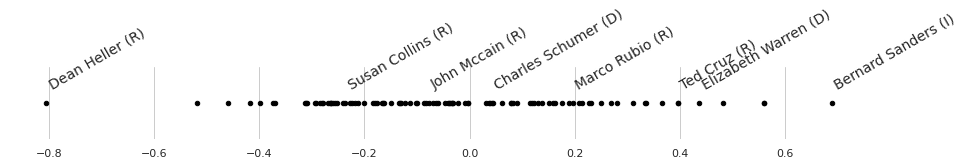

In [ ]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(12, 1))
ax = plt.axes([0, 0, 1, 1], frameon=False)
for index in range(authors.shape[0]):
  ax.scatter(authors["ideal_point"][index], 0, c='black', s=20)
  if authors["name"][index] in selected_authors:
      ax.annotate(author_map[index],
                  xy=(authors["ideal_point"][index], 0.), 
                  xytext=(authors["ideal_point"][index], 0), rotation=30, size=14)
ax.set_yticks([])